In [1]:
%%file demo
4 5
0 10 1 20 2 20 3 40 4 10
1 20 0 10 3 30 2 50 4 30
2 30 1 20 4 12 3 40 0 10
4 50 3 30 2 15 0 20 1 15

Overwriting demo


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from random import randint, shuffle, sample
from sys import argv

In [28]:
rep = [1, 2, 0, 1, 2, 3, 1, 2, 0, 3, 0, 0, 1, 0, 3, 3, 2, 2, 3, 1]

In [49]:
class Schedule():
    def __init__(self, file, rep):
        self.file = file
        self.rep = rep
        with open(file) as f:
            self.n, self.m = [int(x) for x in f.readline().split()]
            self.jobs = np.zeros((self.n, self.m, 2), dtype=int)
            i = 0
            for line in f:
                self.jobs[i] = np.array([int(x) for x in line.split()]).reshape(self.m, 2)
                i += 1
    
    def jssp(self, rep):
        mstart = np.zeros((self.m), dtype=int)
        jend = np.zeros((self.m), dtype=int)
        idxs = np.zeros((self.n), dtype=int)
        makespan = 0

        for e in rep:
            i = idxs[e]
            idxs[e] += 1
            midx = self.jobs[e, i, 0]
            time = self.jobs[e, i, 1]
            mstart[midx] = max(mstart[midx], jend[e]) + time
            jend[e] = mstart[midx]

            if mstart[midx] > makespan:
                makespan = mstart[midx]
        return makespan

    def RandomSampling(self):
        array_spans = []
        new_arreglo = []
        for i in range(100):
            new_arreglo = random.sample(self.rep, len(self.rep))
            makespan = self.jssp(new_arreglo)
            # if len(array_spans) == 0:
            array_spans.append(makespan)

            # if makespan <= array_spans[-1]:
            #     array_spans.append(makespan)
            # else:
            #     array_spans.append(array_spans[-1])
        
        return array_spans

    def Genetic(self, ps = 100, pc = 1.0, pm = 0.05, mit = 100):
        final_array = []
        def ComputeDAG(s):
            G = []
            for t in s: G.append([])
            G.append([])
            T = [0 for j in range(self.n)]
            last_task_job = [-1 for j in range(self.n)]
            tasks_resource = [[-1 for j in range(self.n)] for m in range(self.m)]
            st = [] 
            for i in range(len(s)):
                j = s[i]
                t = T[j]
                st.append(t)
                r = self.jobs[j][t][0]
                if t + 1 == len(self.jobs[j]): G[-1].append(i)
                if t > 0: G[i].append(last_task_job[j])
                G[i].extend([tasks_resource[r][j2] for j2 in range(self.n)
                             if j2 != j and tasks_resource[r][j2] > -1])
                T[j] = T[j] + 1
                last_task_job[j] = i
                tasks_resource[r][j] = i
            return G, st

        def ComputeStartTimes(s):
            G, st = ComputeDAG(s)
            C = [0 for t in G]
            for i in range(len(G)):
                if len(G[i]) == 0: C[i] = 0
                else: C[i] = max(C[k] + self.jobs[s[k]][st[k]][1] for k in G[i])
            return C

        def InitPopulation(ps):
            gene = [j for j in range(self.n) for t in self.jobs[j]]
            population = []
            for i in range(ps):
                shuffle(gene)
                population.append([j for j in gene])
            return population

        def Crossover(p1, p2):      
            def Index(p1):
                ct = [0 for j in range(self.n)]
                s = []
                for i in p1:
                    s.append((i, ct[i]))
                    ct[i] = ct[i] + 1
                return s
            idx_p1 = Index(p1)
            idx_p2 = Index(p2)
            nt = len(idx_p1) 
            i = randint(1, nt)
            j = randint(0, nt-1)
            k = randint(0, nt)
            implant = idx_p1[j:min(j+i,nt)] + idx_p1[:i - min(j+i,nt) + j]

            lft_child = idx_p2[:k]
            rgt_child = idx_p2[k:]
            for jt in implant:
                if jt in lft_child: lft_child.remove(jt)
                if jt in rgt_child: rgt_child.remove(jt)

            child = [ job for (job, task) in lft_child + implant + rgt_child ]
            return child

        def Mutation(p):
            nt = len(p)
            i = randint(0, nt - 1)
            j = randint(0, nt - 1)
            m = [job for job in p]
            m[i], m[j] = m[j], m[i]
            return m

        pop = [(ComputeStartTimes(g)[-1], g) for g in InitPopulation(ps)]
        for it in range(1, mit+1):
            shuffle(pop)
            hpop = int(len(pop) / 2)
            for i in range(hpop):
                if random.random() < pc:
                    ch1 = Crossover(pop[i][1], pop[hpop + i][1])
                    ch2 = Crossover(pop[hpop + i][1], pop[i][1])
                    if random.random() < pm:
                        ch1 = Mutation(ch1)
                    if random.random() < pm:
                        ch2 = Mutation(ch2)
                    pop.append((ComputeStartTimes(ch1)[-1], ch1))
                    pop.append((ComputeStartTimes(ch2)[-1], ch2))
            final_array.append(pop[0])
            pop.sort()
            pop = pop[:ps]

        return final_array
    
    def Grafics(self):
        x = self.RandomSampling()
        y = self.Genetic()
        plt.title('Makespans through 100 iterations')
        plt.xlabel('# of iterations')
        plt.ylabel('# of makespans')
        plt.plot(x)
        plt.plot(y)
        plt.show()
             

ValueError: ignored

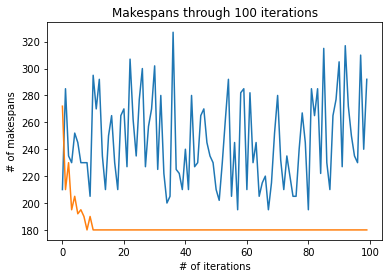

In [50]:
jssp = Schedule('demo', rep)
jssp.Grafics()

Se puede observar como el random sampling (como su nombre lo indica) es completamente aleatorio en cada interación. En la función hay una parte comentada, una validación que si el makespan era mayor al ultimo valor añadido que se repitiera, para dar la sensación de que aprende, sin embargo para efectos visuales he desactivado esa función. Se puede ver como el algoritmo generico si aprende a medida que las iteraciones aumentan. Cabe destacar que al ser un problema pequeño llega al minimo bastante rapido.

**NOTA**: Al realizarlo por tres minutos, llegaba tan rapido el genetico que no se llegaba a apreciar bien en la grafica ninguno de los algoritmos, es por eso que se opto por solo hacer 100 iteraciones.